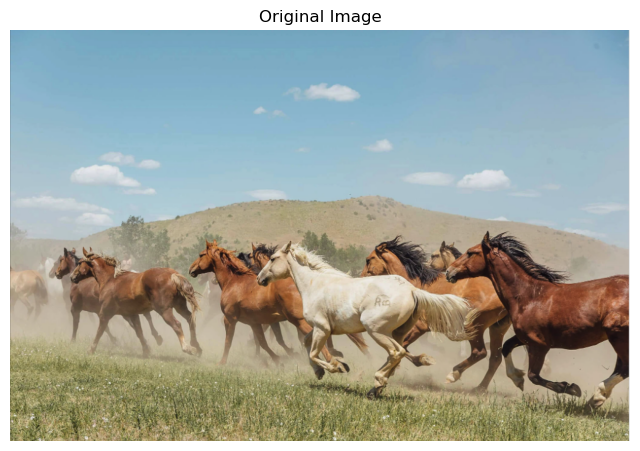

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

interactive_fig = None
interactive_fig_styles = None

def plot_images(images, titles, figure_size):
    %matplotlib inline
    if interactive_fig is not None:
        plt.close(interactive_fig)
    if interactive_fig_styles is not None:
        plt.close(interactive_fig_styles)
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked)    

image = cv2.imread('horses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image], ['Original Image'], 8)


In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [2]:
#masks = mask_generator.generate(image)
#with open('masks.pkl', 'wb') as file:
#    pickle.dump(masks, file)
#print(masks[0].keys())

import pickle

with open('masks.pkl', 'rb') as file:
    masks = pickle.load(file)
    print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


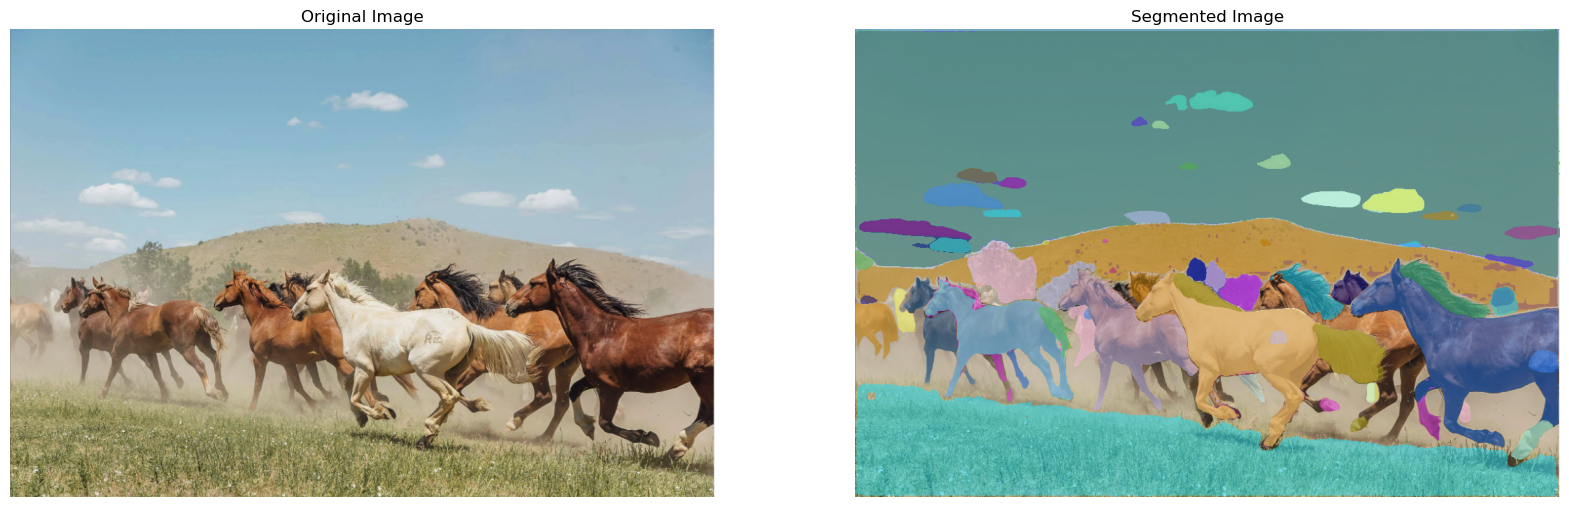

In [3]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
plot_images([image, annotated_image], ['Original Image', 'Segmented Image'], 20)

In [4]:
import os
import glob

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
style_image_file = './styles/style-2.jpg'

org_image = cv2.imread('horses.png')
#style_image = cv2.imread(style_image_file)

### sort masks according to area descendingly
sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

segmented_masks = [
    mask['segmentation']
    for mask in sorted_masks
]

<IPython.core.display.Javascript object>


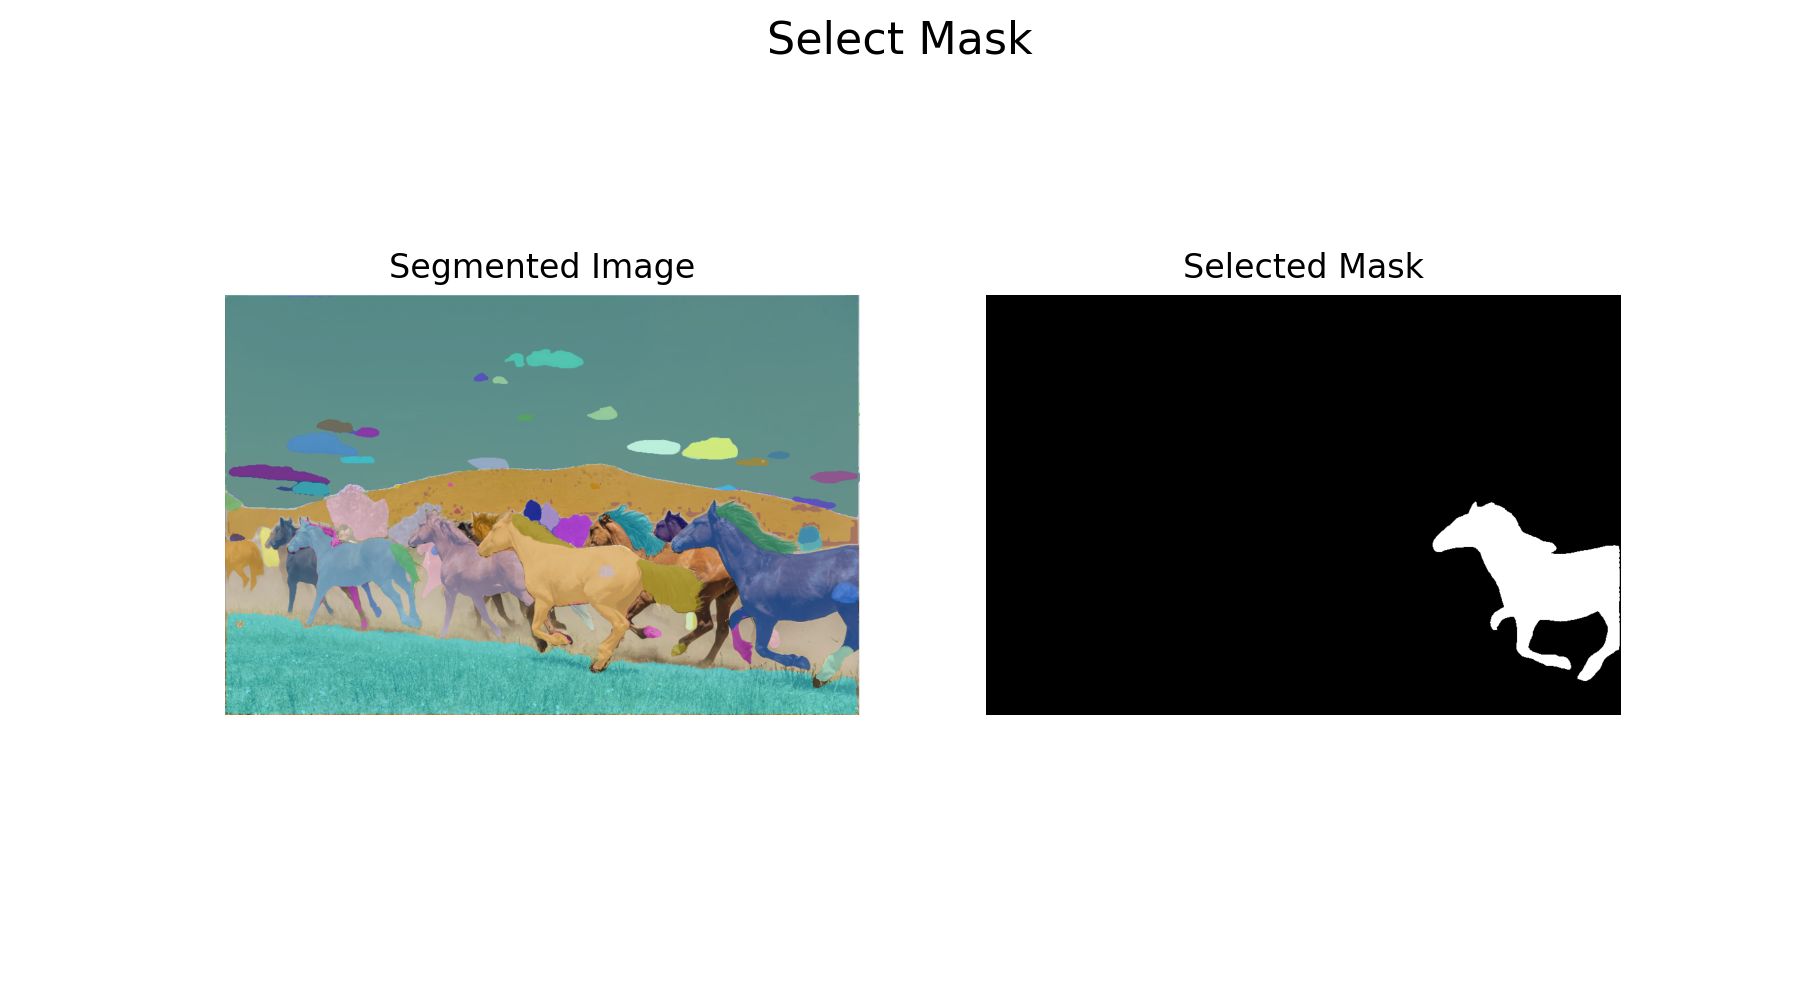

<IPython.core.display.Javascript object>


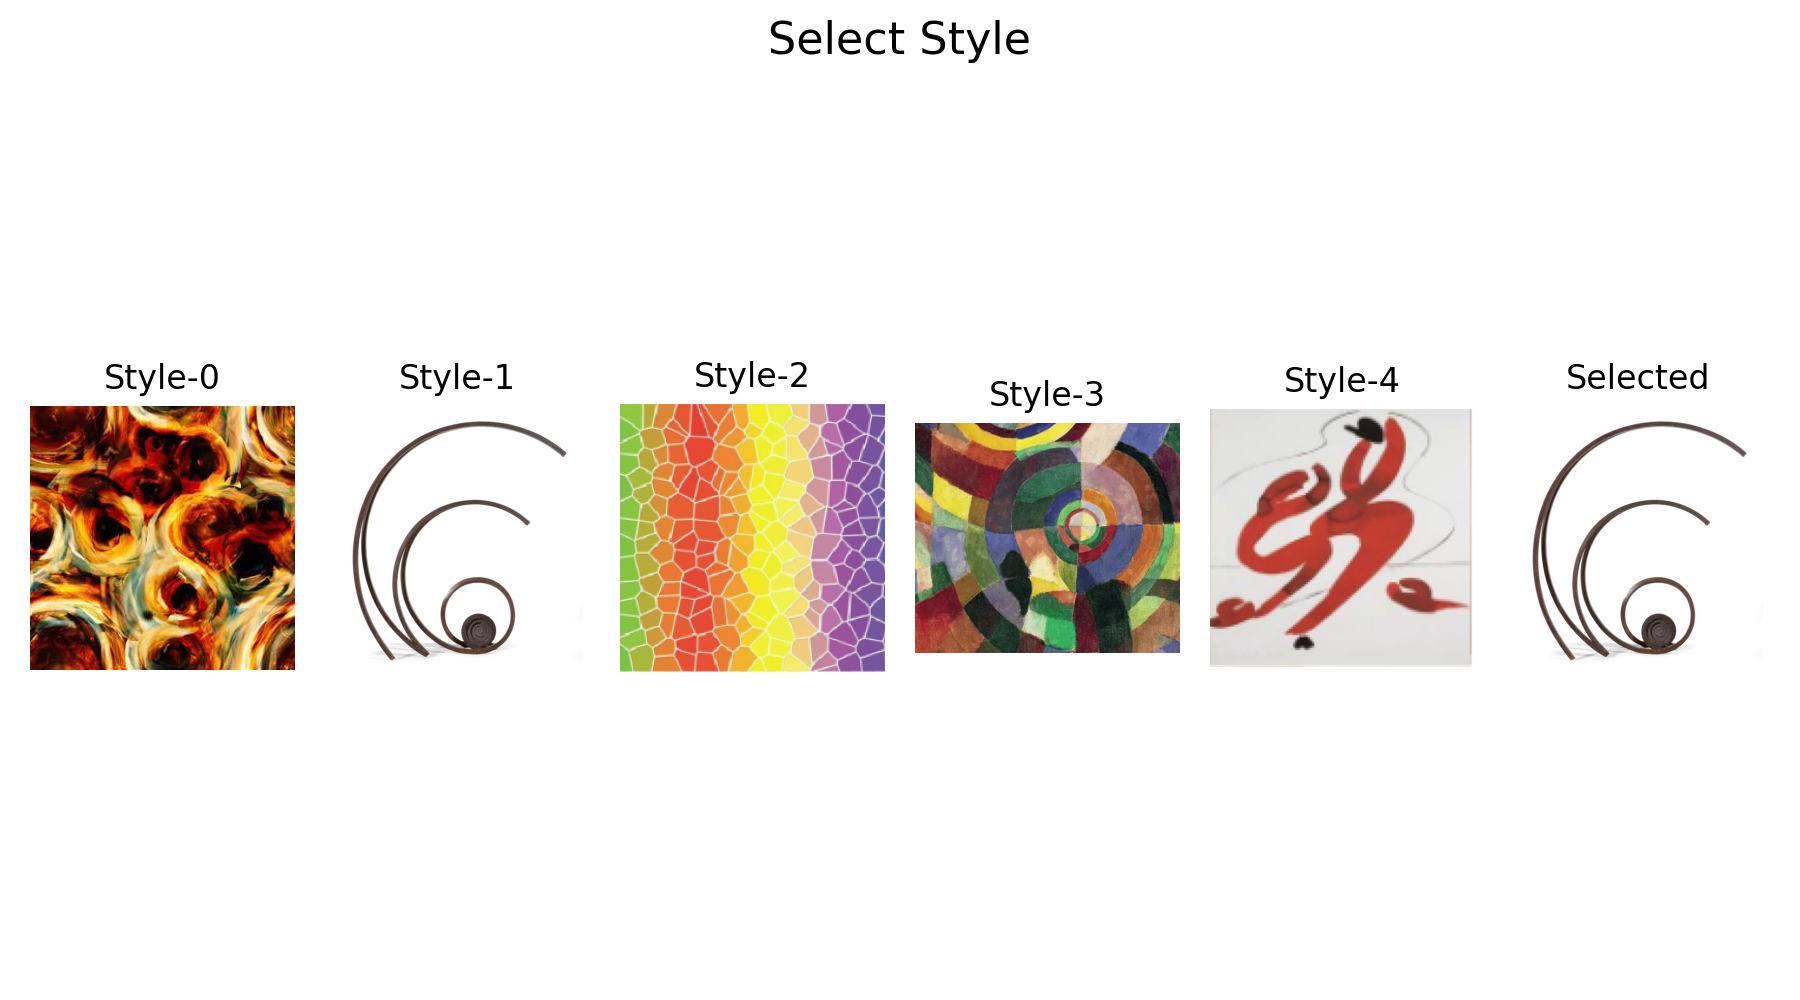

Dropdown(description='Algorithm:', options=('Style And Mask', 'Mask And Style', 'BBox Mask and Style'), value=…

Button(description='Process', style=ButtonStyle())

<IPython.core.display.Javascript object>


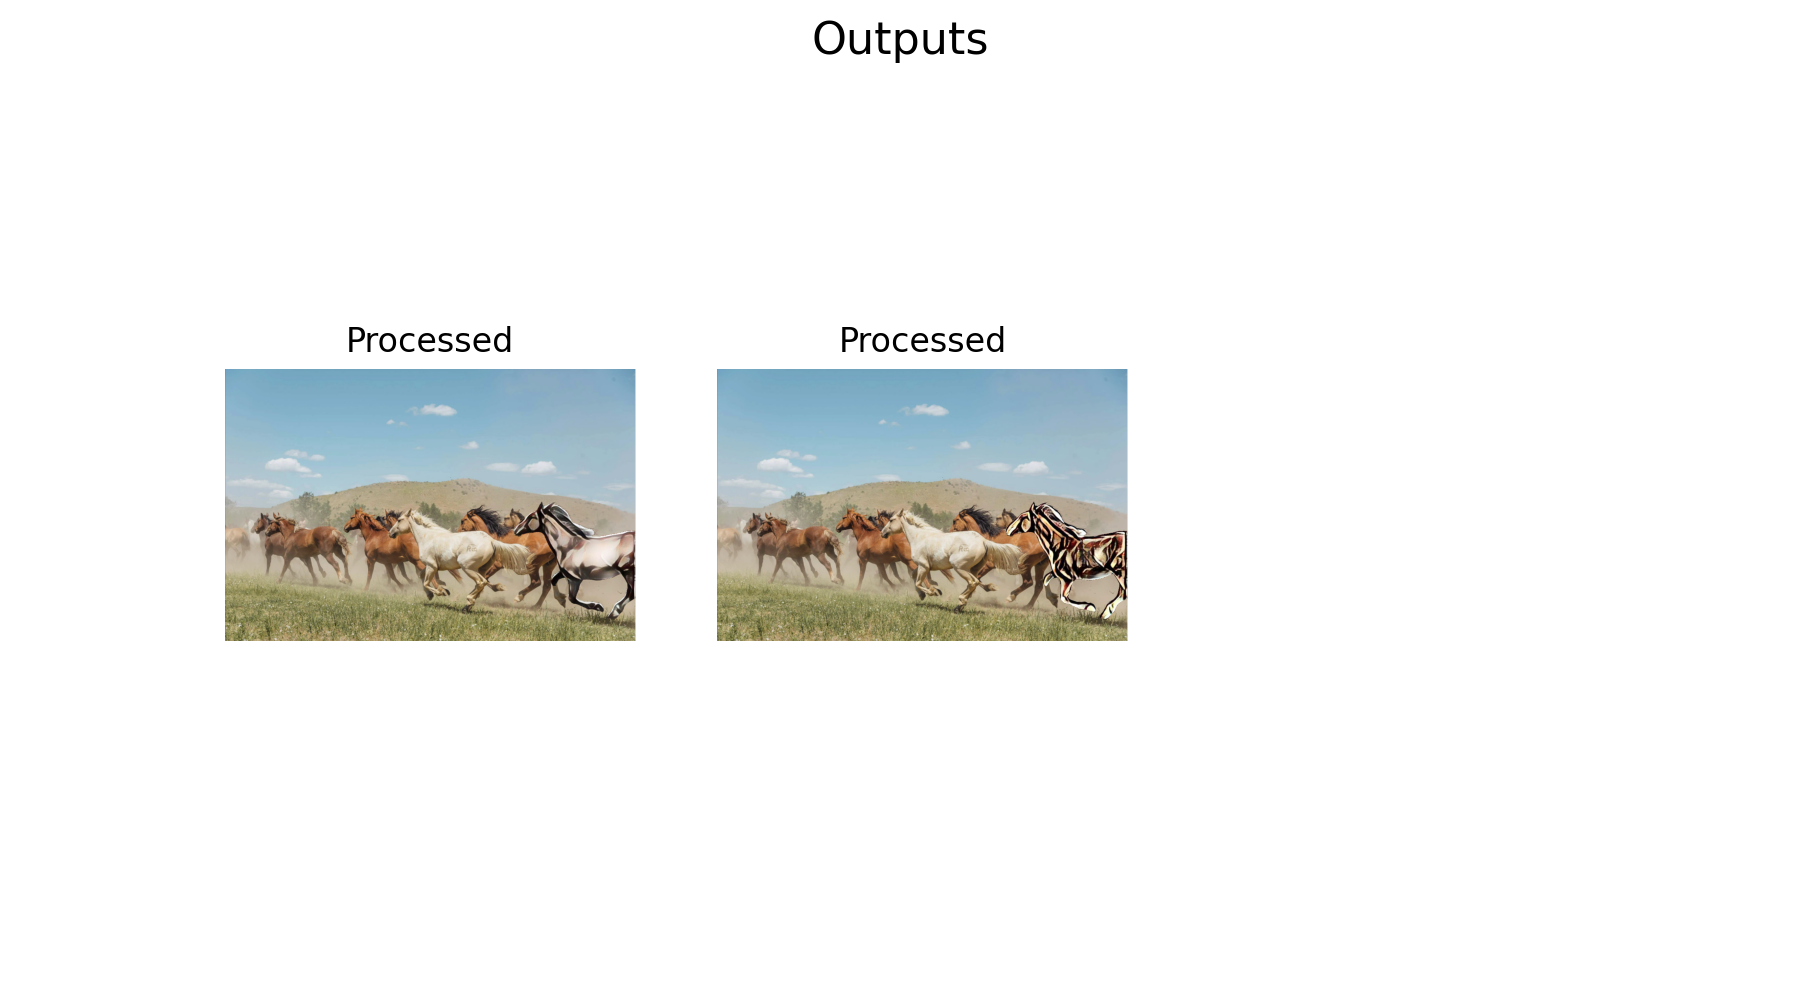

Text(0.5, 0.98, 'Outputs')

Style And Mask processing...


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Mask And Style processing...


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [44]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display
import ipywidgets as widgets


##### Select Mask Begin #####

mask_index = 0
mask = (segmented_masks[mask_index] * 255).astype(np.uint8) 

interactive_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
interactive_fig.suptitle('Select Mask', fontsize=16)

implot1 = ax1.imshow(annotated_image)
ax1.set_title('Segmented Image')
ax1.axis('off')
implot2 = ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax2.set_title('Selected Mask')
ax2.axis('off')

def onclick(event):
    global mask 
    global mask_index
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        pixel_value = annotated_image[y, x]
        for index, segmented_mask in enumerate(segmented_masks):
            new_mask = (segmented_mask * 255).astype(np.uint8)
            pixel_value = new_mask[y, x]
            if pixel_value == 255:
                mask = (segmented_masks[index] * 255).astype(np.uint8) 
                mask_index = index
                implot2.set_data(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
                interactive_fig.canvas.draw_idle()
                break

implot1.figure.canvas.mpl_connect('button_press_event', onclick)
##### Select Mask End #####

##### Select Style Begin #####
style_images = [cv2.cvtColor(cv2.imread(f'./styles/style-{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(5)]
interactive_fig_styles, axs = plt.subplots(1, 6, figsize=(9, 5))
interactive_fig_styles.suptitle('Select Style', fontsize=16)

image_titles = ['Style-0', 'Style-1', 'Style-2', 'Style-3', 'Style-4', 'Selected']

for i, ax in enumerate(axs[:-1]):
    ax.imshow(style_images[i])
    ax.set_title(image_titles[i])
    ax.axis('off')

ax_st_selected = axs[-1]
implot_st_selected = ax_st_selected.imshow(style_images[0])
ax_st_selected.set_title(image_titles[-1])
ax_st_selected.axis('off')
style_image_file = f'./styles/style-0.jpg'

def onclick_style(event):
    global style_image_file
    for i, ax in enumerate(axs[:-1]):
        if event.inaxes == ax:
            axs[-1].clear() 
            axs[-1].imshow(style_images[i])
            axs[-1].set_title(image_titles[-1]) 
            axs[-1].axis('off')
            style_image_file = f'./styles/style-{i}.jpg'
            break
    interactive_fig_styles.canvas.draw_idle()

interactive_fig_styles.canvas.mpl_connect('button_press_event', onclick_style)
##### Select Style End #####

plt.tight_layout() 
plt.show()


##### Process Begin #####
algorithms=['Style And Mask', 'Mask And Style', 'BBox Mask and Style']
dropdown = widgets.Dropdown(
    options=algorithms,  
    value='Style And Mask',
    description='Algorithm:',
    disabled=False,
)

button = widgets.Button(description="Process")

output_index = 0
def on_button_clicked(b):
    global output_index
    selected_index = dropdown.index
    algorithm = algorithms[selected_index]
    print(f'{algorithm} processing...')
    
    if selected_index == 0:
        processed_image_rgb = style_and_mask(style_image_file, mask)
    elif selected_index == 1:
        processed_image_rgb = mask_and_style(style_image_file, mask)
        
    ax = output_axs[output_index]
    ax.imshow(processed_image_rgb)
    ax.set_title(algorithm)
    output_index = otput_index + 1

button.on_click(on_button_clicked)
display(dropdown, button)

outputs, output_axs = plt.subplots(1, 3, figsize=(9, 5))
for i, ax in enumerate(output_axs):
    ax.axis('off')
outputs.suptitle('Outputs', fontsize=16)
##### Process End #####


# 1. Style and Mask

In [42]:
def style_and_mask(style_image_file, mask):
    org_styled_image_file = './output/org-styled.jpg'
    ### style the original image
    os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)

    ### resize styled image to original size    
    org_styled_image = resize_to(cv2.imread(org_styled_image_file), org_image)

    ### regenerating styled-masked image
    final_styled_masked_image = regenerate(org_image, org_styled_image, mask)

    ### plot the images
    return cv2.cvtColor(final_styled_masked_image, cv2.COLOR_BGR2RGB)


def mask_and_style(style_image_file, mask):
    masked_image_file = './output/masked.jpg'
    masked_styled_image_file = './output/masked-styled.jpg'
    ### mask the original image
    masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)

    ### style the masked image
    cv2.imwrite(masked_image_file, masked_image)
    os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + masked_styled_image_file)

    ### resize styled image to original size    
    masked_styled_image = resize_to(cv2.imread(masked_styled_image_file), org_image)

    ### regenerating masked-style image
    final_masked_styled_image = regenerate(org_image, masked_styled_image, mask)

    return cv2.cvtColor(final_masked_styled_image, cv2.COLOR_BGR2RGB)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


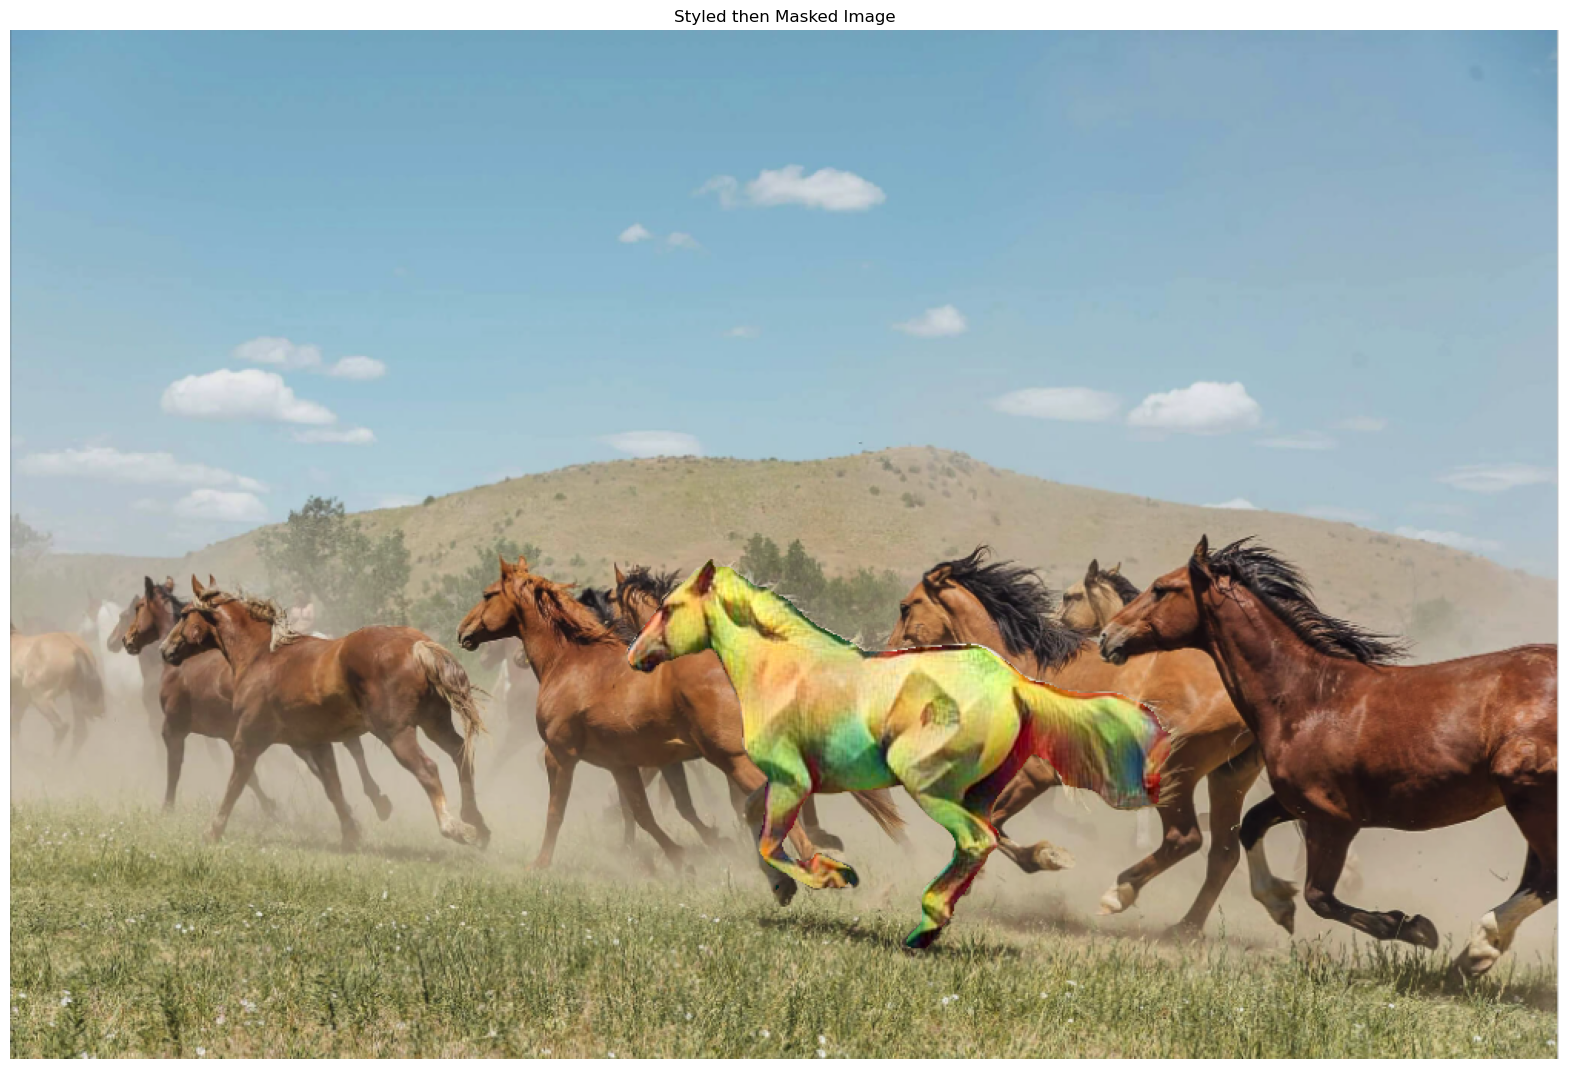

In [13]:
#styled_image_file = './output/styled-0.png'
#org_styled_image_file = './output/org-style-4.jpg'

#### style the original image
#os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)
#
#### resize styled image to original size    
#org_styled_image = resize_to(cv2.imread(org_styled_image_file), org_image)
#
#### regenerating styled-masked image
#final_styled_masked_image = regenerate(org_image, org_styled_image, mask)
#
#### plot the images
#mask_image_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#org_styled_image_rgb = cv2.cvtColor(org_styled_image, cv2.COLOR_BGR2RGB)
#final_styled_masked_image_rgb = cv2.cvtColor(final_styled_masked_image, cv2.COLOR_BGR2RGB)
#plot_images([org_styled_image_rgb, mask_image_rgb, final_styled_masked_image_rgb],
#           ['Styled Image', 'Mask Image', 'Styled then Masked Image'],
#           20)

final_styled_masked_image_rgb = style_and_mask(style_image_file, mask)
plot_images([final_styled_masked_image_rgb], ['Styled then Masked Image'], 20)


# 2. Mask and Style

In [ ]:
masked_image_file = './output/masked-4.jpg'
masked_styled_image_file = './output/masked-style-4.jpg'

### mask the original image
masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)

### style the masked image
cv2.imwrite(masked_image_file, masked_image)
os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + masked_styled_image_file)

### resize styled image to original size    
masked_styled_image = resize_to(cv2.imread(masked_styled_image_file), org_image)

### regenerating masked-style image
final_masked_styled_image = regenerate(org_image, masked_styled_image, mask)

### plot the images
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
masked_styled_image_rgb = cv2.cvtColor(masked_styled_image, cv2.COLOR_BGR2RGB)
final_masked_styled_image_rgb = cv2.cvtColor(final_masked_styled_image, cv2.COLOR_BGR2RGB)

plot_images([masked_image_rgb, masked_styled_image_rgb, final_masked_styled_image_rgb],
           ['Masked Image', 'Masked Styled Image', 'Masked then Styled Image'],
           20)


# 3. Bounding-Box Styled

In [ ]:
bboxed_image_file = './output/bboxed-masked-4.jpg'
bboxed_styled_image_file = './output/bboxed-masked-style-4.jpg'

org_image = cv2.imread('horses.png')
bbox = sorted_masks[mask_index]['bbox']

### bbox and mask the original image
x, y, w, h = bbox
bboxed_mask = mask[y:y+h, x:x+w]
original_bboxed_image = org_image[y:y+h, x:x+w]
masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)

### style the bboxed image
cv2.imwrite(bboxed_image_file, masked_bboxed_image)
os.system('python ' + linear_style_transfer_file + ' ' + bboxed_image_file + ' ' + style_image_file + ' ' + bboxed_styled_image_file)

### resize masked styled image
bboxed_styled_image = cv2.imread(bboxed_styled_image_file)
bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

### regenerating bboxed styles original image
inverse_mask = cv2.bitwise_not(bboxed_mask)
masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 

### inject styled bboxed image into original image
bbox_masked_styled_image = cv2.imread('horses.png')
bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 

### plot the images
mask_image_rgb = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
original_bboxed_image_rgb = cv2.cvtColor(original_bboxed_image, cv2.COLOR_BGR2RGB)
bboxed_styled_image_rgb = cv2.cvtColor(final_bboxed_masked_styled_image, cv2.COLOR_BGR2RGB)
bbox_masked_styled_image_rgb = cv2.cvtColor(bbox_masked_styled_image, cv2.COLOR_BGR2RGB)

plot_images([mask_image_rgb, original_bboxed_image_rgb, bboxed_styled_image_rgb, bbox_masked_styled_image_rgb],
           ['Original Image', 'BBoxed Original Image', 'BBoxed Styled Image', 'BBoxed-Styled Regenerated Image'],
           20)

# 4. Plot the Styled-Masked, Masked-Styled and BBoxed-Masked-Styled Images

In [ ]:
plot_images([final_styled_masked_image_rgb, final_masked_styled_image_rgb, bbox_masked_styled_image_rgb],
           ['Styled Masked Image', 'Masked Styled Image', 'Bboxed Masked Styled Image'],
           30)

In [ ]:
### TODO:

### [DONE] -> masking - styling - regenerate the original image  
### [DONE] -> masking with bounding box - styling - regenerate the original image
### [DONE] -> styling - masking - regenerate the original image

### partial convolution

### choose touching segments and style them with different images, blending